# Import required libraries

In [51]:
import numpy as np
import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from eli5 import show_weights

# Import cleaned dataset

In [52]:
# Load data back for EDA
news_data = pd.read_csv("cleaned_news_data.csv")
news_data.set_index("id", inplace=True)

In [53]:
news_data.shape

(20584, 29)

In [54]:
# View data
news_data.head()

,title,author,text,label,label_translated,title_charcount,text_charcount,title_wordcount,text_wordcount,stopwords_count_text,...,title_pos_noun,title_pos_num,title_pos_pron,title_pos_verb,text_pos_adj,text_pos_adv,text_pos_noun,text_pos_num,text_pos_pron,text_pos_verb
id,,,,,,,,,,,,,,,,,,,,,
0,hous dem aid even see comey letter jason chaff...,Darrell Lucus,hous dem aid even see comey letter jason chaff...,1,fake,81,4930,14,820,406,...,6,0,0,1,102,16,234,3,0,68
1,flynn hillari clinton big woman campu breitbart,Daniel J. Flynn,ever get feel life circl roundabout rather hea...,0,not fake,55,4160,9,710,330,...,5,0,0,1,81,13,208,3,3,45
2,truth might get fire,Consortiumnews.com,truth might get fire octob tension intellig an...,1,fake,33,7692,7,1266,575,...,2,0,0,2,155,33,385,4,3,92
3,civilian kill singl us airstrik identifi,Jessica Purkiss,video civilian kill singl us airstrik identifi...,1,fake,63,3237,10,557,244,...,2,0,1,1,74,5,158,6,12,44
4,iranian woman jail fiction unpublish stori wom...,Howard Portnoy,print iranian woman sentenc six year prison ir...,1,fake,93,938,14,154,64,...,7,0,0,1,13,5,54,2,0,11


## Attempt 3: Logistic regression

### Convert unstructured text into text vectors

## Use Tf-idf Vectorizer

TfidfVectorizer identifies the most important terms in a corpus

**TF- Term Frequency**

$$t=term$$

$$d=document$$

$$
TF(t,d)=\frac{t frequency\ in\ d}{Total\ words\ in\ d}
$$

Using TF alone is not enough to identify the important terms due to stopwords such as "a", "and", "then" etc

**IDF- Inverse Document Frequency**

$$t=term$$

$$D=corpus$$

$$
IDF(t,D)=log\frac{Number\ of\ documents\ in\ D}{Number\ of\ documents\ in\ D\ containing\ t}
$$

That is where IDF comes in, IDF basically gives a less weight on those terms that are common accross multiple documents in the same corpus

**Coming together**
$$
TF-IDF(t,d,D) = TF(t,d)\ *\ IDF(t,D) 
$$


## TF-IDF Analysis

In [55]:
# Init tfidvectorizer
tfidf = TfidfVectorizer(stop_words='english',
                        strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=False, max_features=15000)

In [56]:
# TF-IDF extraction of top n features
def tfidf_top_n_features(tfidf_data, features, n):
    # TFIDF data is the term document matrix without the names, and features are the term names
    # Convert np.array into dataframe (Currently, headers are the features and rows are the score per document)
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns = features)
    # Transpose dataframe so that the headers are the documents and the x axis is the feature name
    tfidf_df = tfidf_df.transpose()
    # Average all document tfidf scores into 1 column
    tfidf_means = np.mean(tfidf_df, axis=1)
    # Previous code output is series data, convert back into df with headers
    tfidf_df_summed = pd.DataFrame({'feature':tfidf_means.index, 'avg_tfidf':tfidf_means.values})
    # Sort to top N features
    tfidf_df_summed = tfidf_df_summed.sort_values(by='avg_tfidf', ascending=False)[:n]
    
    return tfidf_df_summed

## Top 10 features (Title)

In [57]:
# Send docs to fit
tfidf_title_data = tfidf.fit_transform(news_data['title'])
tfidf_title_features = tfidf.get_feature_names()

# Run function
tfidf_top_n_features(tfidf_title_data, tfidf_title_features, 10)

,feature,avg_tfidf
8788,new,0.039671
13317,time,0.037457
14896,york,0.036847
13598,trump,0.027877
1709,breitbart,0.018459
2530,clinton,0.013373
6219,hillari,0.013184
3913,donald,0.010471
4250,elect,0.009104
9024,obama,0.007249


## Top 10 features (Fake)

In [58]:
tfidf_title_fake_data = tfidf.fit_transform(news_data.loc[news_data['label'] == 1]['title'])
tfidf_title_fake_features = tfidf.get_feature_names()

tfidf_top_n_features(tfidf_title_fake_data, tfidf_title_fake_features, 10)

,feature,avg_tfidf
10013,trump,0.025166
4427,hillari,0.019497
1782,clinton,0.018802
3031,elect,0.013427
10578,war,0.009488
6573,new,0.009249
10447,video,0.008650
3477,fbi,0.008519
10527,vote,0.008319
8375,russia,0.008278


In [59]:
tfidf_title_fake_data = tfidf.fit_transform(news_data.loc[news_data['label'] == 1]['text'])
tfidf_title_fake_features = tfidf.get_feature_names()

tfidf_top_n_features(tfidf_title_fake_data, tfidf_title_fake_features, 10)

,feature,avg_tfidf
13705,trump,0.039962
2388,clinton,0.036029
6098,hillari,0.025499
4142,elect,0.022185
9817,peopl,0.020474
12684,state,0.020206
11551,said,0.018133
14423,vote,0.018056
4187,email,0.017335
7667,like,0.016695


## Top 10 features (Not fake)

In [60]:
tfidf_title_notfake_data = tfidf.fit_transform(news_data.loc[news_data['label'] == 0]['title'])
tfidf_title_notfake_features = tfidf.get_feature_names()

tfidf_top_n_features(tfidf_title_notfake_data, tfidf_title_notfake_features, 10)

,feature,avg_tfidf
5932,new,0.054130
8910,time,0.051869
9888,york,0.051848
9097,trump,0.031446
1097,breitbart,0.029396
2549,donald,0.013794
7694,say,0.008739
1637,clinton,0.007524
6072,obama,0.007170
1114,brief,0.006804


In [61]:
tfidf_title_notfake_data = tfidf.fit_transform(news_data.loc[news_data['label'] == 0]['text'])
tfidf_title_notfake_features = tfidf.get_feature_names()

tfidf_top_n_features(tfidf_title_notfake_data, tfidf_title_notfake_features, 10)

,feature,avg_tfidf
8758,mr,0.065035
11550,said,0.050767
13766,trump,0.048545
10318,presid,0.023907
12703,state,0.023430
9826,peopl,0.020120
9009,new,0.019038
14907,year,0.018662
13513,time,0.017341
7704,like,0.017234


# Model training

## Split data into train/test split

In [62]:
# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(news_data['title'], news_data['label'], test_size=0.2)

In [63]:
# Check distribution
print(f"Train: {X_train.shape[0]} & {y_train.shape[0]}")
print(f"Test: {X_test.shape[0]} & {y_test.shape[0]}")

Train: 16467 & 16467
Test: 4117 & 4117


## Convert unstructured text into term frequency matrix

In [64]:
# Init tfidvectorizer again for training with different parameters
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

# Send all docs to fit
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [65]:
# Init logistic regression for k-fold and training
lr = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300)

## Perform k-fold cross validation to estimate the average performance of the model

In [66]:
# Init Stratified K fold cross validation object
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Run k-fold using logistic regression
cv_results = cross_val_score(lr, tfidf_train, y_train, cv=sf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parall

In [67]:
# Print performance of each training and the average training score
for score in cv_results:
    print(f"Score: {score :.5f}")

print(f"Mean score: {cv_results.mean() :.5f}")

Score: 0.92957
Score: 0.93868
Score: 0.92742
Score: 0.93714
Score: 0.93532
Mean score: 0.93362


## Train using logistic regression

In [68]:
# Train
lr.fit(tfidf_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0,
                     scoring='accuracy', verbose=3)

## Check the accuracy of the model

### Confusion Matrix

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

<AxesSubplot:>

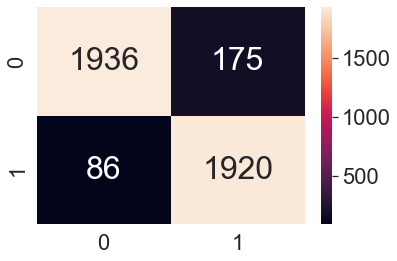

In [69]:
# Predict test dataset
y_test_pred = lr.predict(tfidf_test)

# Print confusion matrix
f = plt.figure(figsize=(6,4))
sb.heatmap(cm:=confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 32})

### Accuracy metrics

In [70]:
# Get overall accuracy
print("Train Data")
print("Accuracy  :\t", lr.score(tfidf_test, y_test))
print("")

# Get individual accuracy
tpTest = cm[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cm[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cm[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))

print("\nFPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

Train Data
Accuracy  :	 0.9366043235365558

TPR Test :	 0.9571286141575274
TNR Test :	 0.9171009000473709

FPR Test :	 0.08289909995262909
FNR Test :	 0.04287138584247258


In [71]:
# Print classification report
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2111
           1       0.92      0.96      0.94      2006

    accuracy                           0.94      4117
   macro avg       0.94      0.94      0.94      4117
weighted avg       0.94      0.94      0.94      4117



### Receiver Operating Characteristic (ROC) Curve & Area Under Curve (AUC)

1. ROC curves is plotted on sensivity by specificity to measure the separability. The model's ability of being able to tell apart the different classes
1. AUC measures the area underneath the entire ROC curve. When comparing against different models, better thhe AUC, better the model performs

Sensivity also known as True Positive rate
$$
Sensivity\ =\ TPR=\frac{True\ Positives}{True\ Positives\ +\ False\ Negatives}
$$

Specificity also known as False Positive rate
$$
Specificity\ =\ FPR=\frac{False\ Positives}{False\ Positives\ +\ True\ Negatives}
$$

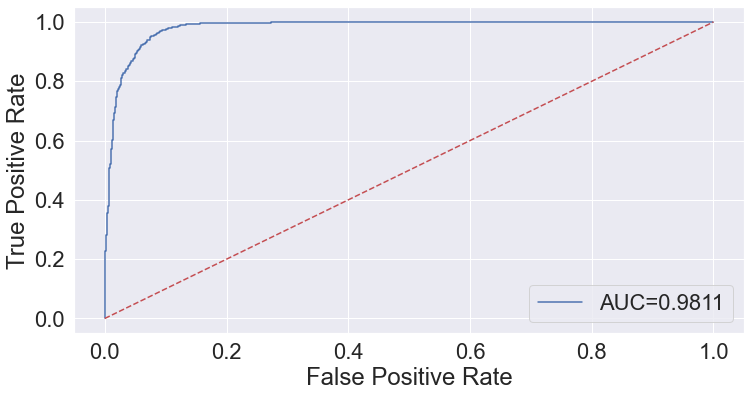

In [72]:
# Run prediction, calculate false positive, true positive rates
y_pred_proba = lr.predict_proba(tfidf_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# Calculate auc score
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
f = plt.figure(figsize=(12,6))
plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Visualize the weights of the model

In [73]:
# visualise the weights defined by the model
show_weights(estimator=lr, feature_names= list(tfidf.get_feature_names()), top=(30, 30))

Weight?,Feature
+9.961,comment
+9.728,apologist
+8.882,hillari
+8.129,hoover
+6.839,hillary
+6.823,us
+6.355,fals
+6.168,fbi
+6.158,honestli
+6.052,reded


## Is title alone enough? What other combiantions can give a higher accuracy rate?

In [74]:
# Functions to train automatically and evaluate the model with ROC curve
def lr_auto_train_test(combinations):
    # Init empty list to contain model objects
    models = []
    stats = []
    
    for combination in combinations:
        # 80-20 split
        X_train, X_test, y_train, y_test = train_test_split(combination, news_data['label'], test_size=0.2)
        
        # Init tfidvectorizer again for training with different parameters
        tfidf = TfidfVectorizer(strip_accents=None,
                                lowercase=False,
                                preprocessor=None,
                                use_idf=True,
                                norm='l2',
                                smooth_idf=True)

        # Send all docs to fit
        tfidf_train = tfidf.fit_transform(X_train)
        tfidf_test = tfidf.transform(X_test)
        
        # Init logistic regression for training
        lr = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300)
        
        # Train
        model = lr.fit(tfidf_train, y_train)
        
        # Record model
        models.append(model)

        # Predict test dataset
        y_test_pred = model.predict(tfidf_test)

        # Print confusion matrix
        f = plt.figure(figsize=(6,4))
        sb.heatmap(cm:=confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 32}).set(title=f"Predictor: {combination.name}", 
                                                                                                                    xlabel='Actual',
                                                                                                                    ylabel='Predicted')
        
        # Print which model we evaluating now
        print(f"Predictor used: {combination.name}")
        
        # Get overall accuracy
        print("Train Data")
        print("Accuracy  :\t", model.score(tfidf_test, y_test))
        print("")

        # Get individual accuracy
        tpTest = cm[1][1] # True Positives : Good (1) predicted Good (1)
        fpTest = cm[0][1] # False Positives : Bad (0) predicted Good (1)
        tnTest = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
        fnTest = cm[1][0] # False Negatives : Good (1) predicted Bad (0)

        print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
        print("TNR Test :\t", (tnTest/(tnTest + fpTest)))

        print("\nFPR Test :\t", (fpTest/(fpTest + tnTest)))
        print("FNR Test :\t", (fnTest/(fnTest + tpTest)))
        
        # Print classification report
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        
        
        # Run prediction, calculate false positive, true positive rates
        y_pred_proba = model.predict_proba(tfidf_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        # Record fpr, tpr for ROC plotting
        stats.append((fpr,tpr, y_test, y_pred_proba))
        
    
    
    # After all models, plot combined ROC curve
    f = plt.figure(figsize=(12,6))
    
    for combination, model, (fpr, tpr, y_test, y_pred_proba) in zip(combinations, models, stats):
        # Calculate auc score
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label=f"{combination.name} AUC={auc:.4f}")
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC curve between different models')
    plt.legend(loc=4)
    plt.show()
        



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Predictor used: Title only
Train Data
Accuracy  :	 0.934661161039592

TPR Test :	 0.9598257502420136
TNR Test :	 0.90931253047294

FPR Test :	 0.09068746952705997
FNR Test :	 0.04017424975798645
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2051
           1       0.91      0.96      0.94      2066

    accuracy                           0.93      4117
   macro avg       0.94      0.93      0.93      4117
weighted avg       0.94      0.93      0.93      4117



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.7s remaining:   43.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


Predictor used: Text only
Train Data
Accuracy  :	 0.9579791110031577

TPR Test :	 0.9612133267031328
TNR Test :	 0.9548907882241215

FPR Test :	 0.04510921177587844
FNR Test :	 0.03878667329686723
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2106
           1       0.95      0.96      0.96      2011

    accuracy                           0.96      4117
   macro avg       0.96      0.96      0.96      4117
weighted avg       0.96      0.96      0.96      4117



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.2s remaining:   42.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


Predictor used: Title & text
Train Data
Accuracy  :	 0.96429438911829

TPR Test :	 0.9679012345679012
TNR Test :	 0.9608030592734226

FPR Test :	 0.03919694072657744
FNR Test :	 0.03209876543209877
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2092
           1       0.96      0.97      0.96      2025

    accuracy                           0.96      4117
   macro avg       0.96      0.96      0.96      4117
weighted avg       0.96      0.96      0.96      4117



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Predictor used: Author & title
Train Data
Accuracy  :	 0.9939276171969881

TPR Test :	 0.9936893203883496
TNR Test :	 0.9941662615459407

FPR Test :	 0.00583373845405931
FNR Test :	 0.006310679611650485
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2057
           1       0.99      0.99      0.99      2060

    accuracy                           0.99      4117
   macro avg       0.99      0.99      0.99      4117
weighted avg       0.99      0.99      0.99      4117



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.5s remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


Predictor used: Author & text
Train Data
Accuracy  :	 0.9718241437940248

TPR Test :	 0.972180824639841
TNR Test :	 0.9714828897338403

FPR Test :	 0.028517110266159697
FNR Test :	 0.027819175360158967
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2104
           1       0.97      0.97      0.97      2013

    accuracy                           0.97      4117
   macro avg       0.97      0.97      0.97      4117
weighted avg       0.97      0.97      0.97      4117



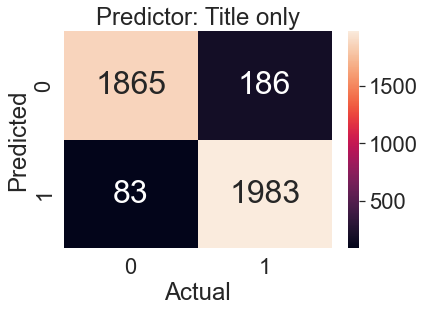

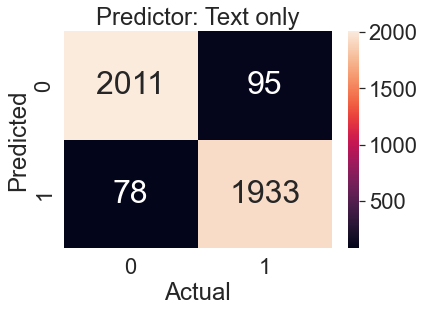

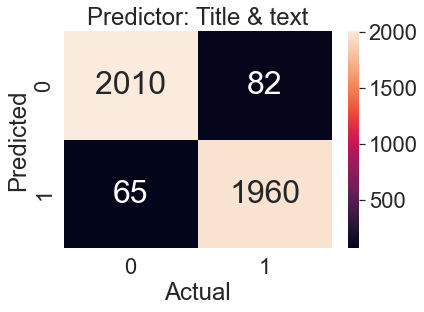

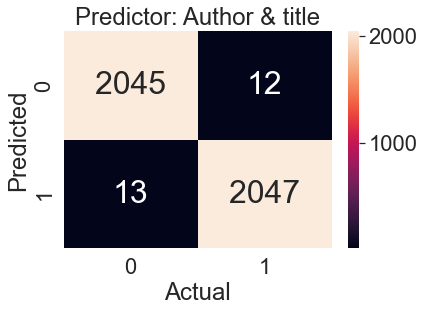

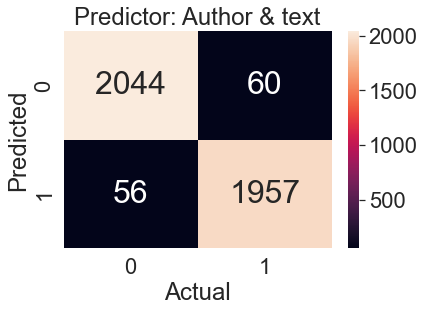

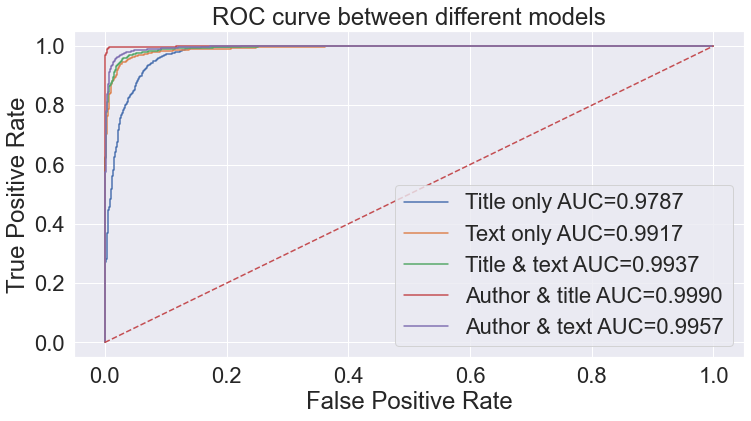

In [75]:
combinations = [news_data['title'].rename("Title only"), 
                news_data['text'].rename("Text only"), 
                (news_data['title'] + " " + news_data['text']).rename("Title & text"), 
                (news_data['author'] + " " + news_data['title']).rename("Author & title"), 
                (news_data['author'] + " " + news_data['text']).rename("Author & text")
               ]

lr_auto_train_test(combinations)